<a href="https://colab.research.google.com/github/YasminBougammoura/nlp/blob/main/BigramModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
%reset -f

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("/content/names.txt",'r').read().splitlines()

In [31]:
#words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# BUILDING THE VOCABULARY MAPPING
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [15]:
# BUILDING THE DATASET
# Training (Train parameters), Validation (Hyperparameters), Testing (Evaluate performance) split

def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [94]:
#X.shape

torch.Size([228146, 3])

In [5]:
# LOOK UP TABLE THAT EMBEDS 27 CHAR INTO A LOWER DIM SPACE - INPUT LAYER

'''
X.shape
C[X].shape
X[13,2]
C[X][13,2] # We get the 2-dim embedding of element [13,2] of our input
C[1] # This will be identical to the previous value
'''

C = torch.randn((27,2))
emb = C[Xtr]

In [ ]:
'''
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1) #dependent on block_size
'''

In [ ]:
'''
torch.cat(torch.unbind(emb,1),1) #indipendent of block_size
'''

In [ ]:
emb.view(32,6)

In [6]:
# HIDDEN LAYER

W1 = torch.randn((6,100))
b1 = torch.randn(100)

h = torch.tanh(emb.view(-1,6) @ W1 + b1) # -1 is equivalent to emb.shape[0]

In [7]:
# FINAL LAYER

W2 = torch.randn((100,27))
b2 = torch.randn(27)

logits = h @ W2 + b2
counts = logits.exp()
prob = counts/counts.sum(1, keepdim = True)

In [9]:
 # Extracting the probability assigned by the network to the correct output

loss = -prob[torch.arange(228146), Y].log().mean()

In [65]:
# NEURAL NETWORK

g = torch.Generator().manual_seed(21436789)
C = torch.randn((27,10))
W1 = torch.randn((30,200))
b1 = torch.randn(200)
W2 = torch.randn((200,27))
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]

In [66]:
sum(p.nelement() for p in parameters)

11897

In [67]:
for p in parameters:
  p.requires_grad = True

In [41]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre


In [68]:
lri = []
lossi = []
stepi = []

In [82]:


for i in range(200000):

  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,30) @ W1 + b1)
  logits = h @ W2 + b2
  #counts = logits.exp()
  #prob = counts/counts.sum(1, keepdim = True)
  #loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits,Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  #lr = lrs[i]
  lr = 10**-1 if i < 100000 else 10**-2
  for p in parameters:
    p.data += -lr*p.grad

  #tracks
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

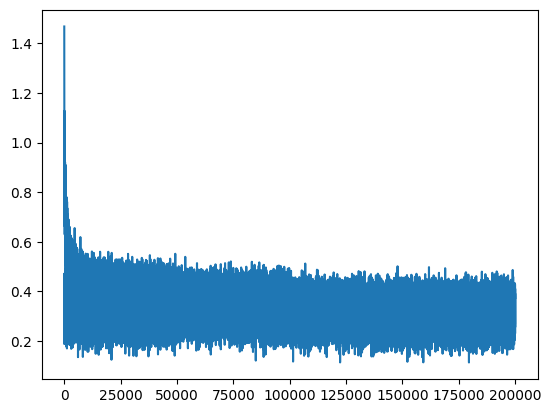

In [83]:
plt.plot(stepi,lossi)

In [35]:
print(loss.item())

2.2311508655548096


In [84]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.0887, grad_fn=<NllLossBackward0>)

In [85]:
# Evaluating the loss

emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1410, grad_fn=<NllLossBackward0>)

In [ ]:
plt.plot(lri,lossi)

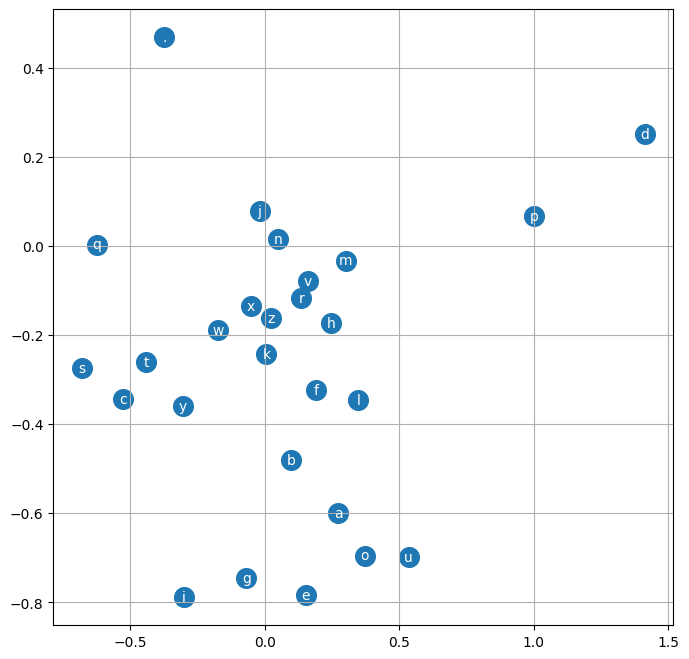

In [81]:
# Visualize character embedding

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


In [87]:
# GENERATING FROM THE MODEL

g = torch.Generator().manual_seed(2147483647)
block_size = 3

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:

    emb = C[torch.tensor([context])] #(1,block_size,d)
    h = torch.tanh(emb.view(1,-1)@W1 + b1)
    logits = h@W2 + b2
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, generator = g). item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

junide.
jakaqua.
presay.
adria.
jirnito.
sabe.
ter.
kalinaa.
zamilenias.
deyaire.
amel.
sejaicayla.
terinvelyn.
afortumi.
phynsleigh.
ann.
core.
yaenocelynn.
brittie.
bin.
